In [1]:
import os
import random
import re
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from IPython.display import Image
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.preprocessing.text import Tokenizer

from google.colab import drive

# For visualizations
from mlxtend.plotting import heatmap, plot_decision_regions

# Download NLTK stopwords
import nltk
nltk.download('stopwords')

# Set up matplotlib for inline display
%matplotlib inline

# If working in Google Colab, uncomment the following line
drive.mount('/content/gdrive')

# Set a random seed for reproducibility
random.seed(2)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Mounted at /content/gdrive


## Data Cleaning and Processing

In [2]:
stop_words = set(stopwords.words('english'))

def load_and_prepare_data(file_path):
    """
    Load the dataset and prepare it for processing.

    Parameters:
    file_path (str): The path to the dataset file.

    Returns:
    pd.DataFrame: The loaded dataset.
    """
    df = pd.read_csv(file_path)
    return df

def convert_release_date(df):
    """
    Convert release_date to datetime and calculate age_of_game.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the release_date column.

    Returns:
    pd.DataFrame: The DataFrame with the age_of_game column added.
    """
    df['release_date'] = pd.to_datetime(df['release_date'], format='%d %b, %Y', errors='coerce')
    current_date = datetime.now()
    df['age_of_game'] = df['release_date'].apply(lambda x: current_date.year - x.year if pd.notnull(x) else None)
    return df

def clean_discounted_price(df):
    """
    Clean the discounted_price column by handling 'Free' values and removing currency symbols.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the discounted_price column.

    Returns:
    pd.DataFrame: The cleaned DataFrame.
    """
    df['discounted_price'] = df['discounted_price'].replace('Free', '0')
    df['discounted_price'] = df['discounted_price'].str.replace('₹', '').str.replace(',', '').astype(float)
    return df

def remove_invalid_release_dates(df, cutoff_date='2024-05-09'):
    """
    Remove games with release dates after the data was scraped.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the release_date column.
    cutoff_date (str): The cutoff date to filter the release_date column.

    Returns:
    pd.DataFrame: The filtered DataFrame.
    """
    cutoff = pd.to_datetime(cutoff_date)
    df = df[df['release_date'] <= cutoff]
    return df

def split_genres(df, column='genres'):
    """
    One-hot encode the genres column.

    Parameters:
    df (pd.DataFrame): The DataFrame with a genres column.
    column (str): The name of the genres column to be split.

    Returns:
    pd.DataFrame: The DataFrame with one-hot encoded genre columns.
    """
    genres_split = df[column].str.get_dummies(sep=', ')
    df = pd.concat([df, genres_split], axis=1)
    return df

def transform_to_binary_class(df, column_name, threshold):
    """
    Transform a numerical column into binary classes.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the column to transform.
    column_name (str): The name of the column to transform.
    threshold (float): The threshold to determine binary classes.

    Returns:
    pd.DataFrame: The DataFrame with a new binary class column.
    """
    df['binary_class'] = df[column_name].apply(lambda x: 'positive' if x >= threshold else 'negative')
    return df

def preprocess_text(text, stop_words):
    """
    Preprocess text by lowercasing, removing punctuation, and stopwords.

    Parameters:
    text (str or other): The text to preprocess. If not a string, it will be converted to a string.
    stop_words (set): A set of stopwords to remove from the text.

    Returns:
    str: The preprocessed text.
    """
    # Ensure the input is a string
    text = str(text)
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = ' '.join(word for word in text.split() if word not in stop_words)
    return text

def preprocess_dataframe(df, text_column):
    """
    Apply text preprocessing to a specified column in the DataFrame.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the text column.
    text_column (str): The name of the text column to preprocess.

    Returns:
    pd.DataFrame: The DataFrame with preprocessed text.
    """
    df[text_column] = df[text_column].apply(lambda x: preprocess_text(x, stop_words))
    return df

def tokenize_text(df, text_column, num_words=5000, oov_token='<OOV>'):
    """
    Tokenize the text data and limit the vocabulary size.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the text column to tokenize.
    text_column (str): The name of the text column.
    num_words (int): The maximum number of words to keep in the tokenizer's vocabulary.
    oov_token (str): The token for out-of-vocabulary words.

    Returns:
    pd.DataFrame: The DataFrame with tokenized text.
    Tokenizer: The fitted Keras tokenizer instance.
    """
    tokenizer = Tokenizer(num_words=num_words, oov_token=oov_token)
    tokenizer.fit_on_texts(df[text_column])
    df['tokenized_text'] = tokenizer.texts_to_sequences(df[text_column])
    return df, tokenizer

def truncate_pad_data(sequences, max_length):
    """
    Pads and truncates sequences to a specified maximum length.

    Parameters:
    sequences (list of list of int): The tokenized text sequences to pad/truncate.
    max_length (int): The maximum length for the sequences.

    Returns:
    np.ndarray: The padded/truncated sequences as a NumPy array.
    """
    padded_data = tf.keras.preprocessing.sequence.pad_sequences(
        sequences, maxlen=max_length, padding='post', truncating='post', value=0)
    return padded_data

def preprocess_numerical_features(train_df, test_df, columns):
    """
    Scale numerical features using StandardScaler and replace the original columns with the scaled values.

    Parameters:
    train_df (pd.DataFrame): The training dataset.
    test_df (pd.DataFrame): The test dataset.
    columns (list): The list of columns to scale.

    Returns:
    pd.DataFrame, pd.DataFrame: The training and test datasets with scaled numerical features.
    """
    scaler = StandardScaler()
    train_df[columns] = scaler.fit_transform(train_df[columns])
    test_df[columns] = scaler.transform(test_df[columns])

    return train_df, test_df

def encode_labels(df, column):
    """
    Encode binary class labels.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the binary class column.
    column (str): The name of the binary class column.

    Returns:
    pd.Series: The encoded labels.
    """
    label_encoder = LabelEncoder()
    return label_encoder.fit_transform(df[column])

def process_datasets(X_train, X_val, X_test, text_column, max_length=35, num_words=5000):
    """
    Preprocess, tokenize, and pad text data in training, validation, and test datasets.

    Parameters:
    X_train (pd.DataFrame): The training dataset.
    X_val (pd.DataFrame): The validation dataset.
    X_test (pd.DataFrame): The test dataset.
    text_column (str): The name of the text column to process.
    max_length (int): The maximum length for padding sequences.
    num_words (int): The maximum number of words to keep in the tokenizer's vocabulary.

    Returns:
    tuple: The processed training, validation, and test datasets.
    """
    # Preprocess text
    X_train = preprocess_dataframe(X_train, text_column)
    X_val = preprocess_dataframe(X_val, text_column)
    X_test = preprocess_dataframe(X_test, text_column)

    # Tokenize text
    X_train, tokenizer = tokenize_text(X_train, text_column, num_words=num_words)
    X_val['tokenized_text'] = tokenizer.texts_to_sequences(X_val[text_column])
    X_test['tokenized_text'] = tokenizer.texts_to_sequences(X_test[text_column])

    # Pad sequences
    X_train['padded_text'] = list(truncate_pad_data(X_train['tokenized_text'], max_length=max_length))
    X_val['padded_text'] = list(truncate_pad_data(X_val['tokenized_text'], max_length=max_length))
    X_test['padded_text'] = list(truncate_pad_data(X_test['tokenized_text'], max_length=max_length))

    # Drop unnecessary columns
    X_train.drop(columns=[text_column, 'tokenized_text'], inplace=True)
    X_val.drop(columns=[text_column, 'tokenized_text'], inplace=True)
    X_test.drop(columns=[text_column, 'tokenized_text'], inplace=True)

    return X_train, X_val, X_test


def data_cleaning(df):
    """
    Main function to clean and preprocess the data.

    Parameters:
    df (pd.DataFrame): The DataFrame to clean and preprocess.

    Returns:
    pd.DataFrame: The cleaned DataFrame.
    """
    df = convert_release_date(df)
    df = clean_discounted_price(df)
    df = remove_invalid_release_dates(df)
    df = split_genres(df)

    return df

def data_processing(df):
    """
    Main function to process the data, including splitting, encoding, and feature preparation.

    Parameters:
    df (pd.DataFrame): The cleaned DataFrame.

    Returns:
    tuple: The processed training, validation, and test datasets along with labels.
    """
    # Drop unnecessary columns
    columns_to_drop = ['overall_review', 'overall_review_count', 'genres', 'app_id', 'title', 'dlc_available', 'age_rating','win_support', 'mac_support','linux_support',
                       'release_date', 'categories', 'developer','publisher','original_price', 'discount_percentage', 'content_descriptor', 'recent_review','recent_review_%', 'recent_review_count']
    df.drop(columns=columns_to_drop, inplace=True)
    # Drop any rows with null values before any processing
    df.dropna(inplace=True)

    # Split data into train and test
    train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

    # Transform review percentage to binary classes
    threshold = train_df['overall_review_%'].median()
    train_df = transform_to_binary_class(train_df, 'overall_review_%', threshold)
    test_df = transform_to_binary_class(test_df, 'overall_review_%', threshold)

    # Drop unnecessary columns
    columns_to_drop = ['overall_review_%']
    train_df.drop(columns=columns_to_drop, inplace=True)
    test_df.drop(columns=columns_to_drop, inplace=True)

    # Preprocess numerical features (replacing the original columns)
    numerical_columns = ['discounted_price', 'age_of_game', 'awards']
    train_df, test_df = preprocess_numerical_features(train_df, test_df, numerical_columns)

    # Create validation set from the training data
    train_df, val_df = train_test_split(train_df, test_size=0.25, random_state=42)

    # Preprocess text features and drop unnecessary columns
    X_train, X_val, X_test = process_datasets(train_df, val_df, test_df, 'about_description')

    # Encode labels
    y_train = encode_labels(train_df, 'binary_class')
    y_val = encode_labels(val_df, 'binary_class')
    y_test = encode_labels(test_df, 'binary_class')

    # Combine all features (numerical, genre, text)
    X_train = pd.concat([X_train], axis=1)
    X_val = pd.concat([X_val], axis=1)
    X_test = pd.concat([X_test], axis=1)

    # Drop target from X sets
    columns_to_drop = ['binary_class']
    X_train.drop(columns=columns_to_drop, inplace=True)
    X_val.drop(columns=columns_to_drop, inplace=True)
    X_test.drop(columns=columns_to_drop, inplace=True)


    return X_train, X_val, X_test, y_train, y_val, y_test

In [3]:
file_path = 'gdrive/My Drive/steam-games.csv'
df = load_and_prepare_data(file_path)
df_cleaned = data_cleaning(df)
X_train, X_val, X_test, y_train, y_val, y_test = data_processing(df_cleaned)

In [4]:
# Print the shapes of the outputs
print("Shapes:")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_val: {X_val.shape}, y_val: {y_val.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

Shapes:
X_train: (23688, 26), y_train: (23688,)
X_val: (7896, 26), y_val: (7896,)
X_test: (7897, 26), y_test: (7897,)


# Neural Network with all features and learned embeddings

## Prepare features

In [5]:
def prepare_combined_features(X_train, X_val, X_test):
    """
    Prepare combined features by converting padded text to NumPy arrays and combining them with all other features.

    Parameters:
    X_train (pd.DataFrame): The training dataset.
    X_val (pd.DataFrame): The validation dataset.
    X_test (pd.DataFrame): The test dataset.

    Returns:
    tuple: Combined feature arrays for training, validation, and test datasets.
    """
    # Convert padded text to NumPy arrays
    X_train_padded = np.array(X_train['padded_text'].tolist())
    X_val_padded = np.array(X_val['padded_text'].tolist())
    X_test_padded = np.array(X_test['padded_text'].tolist())

    # Get all columns except 'padded_text'
    feature_columns = [col for col in X_train.columns if col != 'padded_text']

    # Combine padded text with other features
    X_train_features = X_train[feature_columns].to_numpy()
    X_val_features = X_val[feature_columns].to_numpy()
    X_test_features = X_test[feature_columns].to_numpy()

    X_train_combined = np.hstack((X_train_padded, X_train_features))
    X_val_combined = np.hstack((X_val_padded, X_val_features))
    X_test_combined = np.hstack((X_test_padded, X_test_features))

    return X_train_combined, X_val_combined, X_test_combined


In [6]:
X_train_combined, X_val_combined, X_test_combined = prepare_combined_features(X_train, X_val, X_test)

## Neural Network Model

Epoch 1/10
371/371 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - binary_accuracy: 0.5192 - loss: 0.9710 - val_binary_accuracy: 0.6016 - val_loss: 0.7003
Epoch 2/10
371/371 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - binary_accuracy: 0.5991 - loss: 0.6924 - val_binary_accuracy: 0.6016 - val_loss: 0.6763
Epoch 3/10
371/371 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_accuracy: 0.6049 - loss: 0.6769 - val_binary_accuracy: 0.6056 - val_loss: 0.6725
Epoch 4/10
371/371 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - binary_accuracy: 0.6055 - loss: 0.6730 - val_binary_accuracy: 0.6075 - val_loss: 0.6695
Epoch 5/10
371/371 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - binary_accuracy: 0.6141 - loss: 0.6688 - val_binary_accuracy: 0.6111 - val_loss: 0.6669
Epoch 6/10
371/371 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - binary_accuracy: 0.6181 - loss: 0.6651 - val_binary_accuracy: 0.6139 - val_loss: 0.6650
Epoch 7/10
371/371 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - binary_accuracy: 0.6298 - loss: 0.6601 - val_binary_accuracy: 0.6182 - val_loss: 0.6636
Epoch 

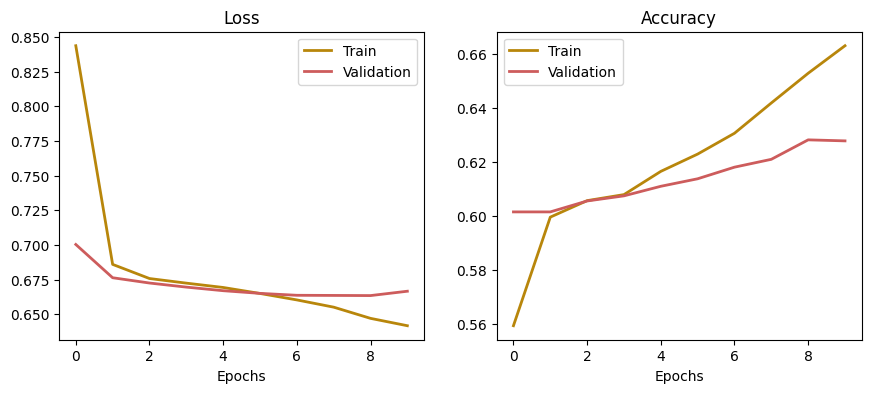

In [7]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, Sequential

# Ensure reproducibility
tf.keras.backend.clear_session()
tf.random.set_seed(1234)

# Final model setup with improved regularization and adjustments
def create_improved_model(vocab_size=5000, embedding_dim=2, num_other_features=10,
                          dense_units=32, dropout_rate=0.4, learning_rate=0.001, max_token_length = 35):
    """Build an improved Keras model using the Sequential API with regularization."""

    # Sequential model for text embeddings
    text_model = Sequential(name="TextModel")
    text_model.add(layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim))
    text_model.add(layers.GlobalAveragePooling1D())

    # Sequential model for additional features
    features_model = Sequential(name="FeaturesModel")
    features_model.add(layers.Input(shape=(num_other_features,)))

    # Define a combined model using functional API to merge Sequential models
    combined_input = tf.keras.Input(shape=(max_token_length + num_other_features,), name='combined_input')

    # Process text part separately
    text_out = text_model(combined_input[:, :max_token_length])

    # Process features part separately
    features_out = combined_input[:, max_token_length:]

    # Concatenate the processed outputs
    concatenated = layers.concatenate([text_out, features_out], name='Concatenate')

    # Define dense layers with improved regularization
    x = layers.Dense(dense_units, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(concatenated)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(int(dense_units / 2), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    output = layers.Dense(1, activation='sigmoid')(x)

    # Build final model
    model = models.Model(inputs=combined_input, outputs=output)
    model.compile(
        loss='binary_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        metrics=[tf.keras.metrics.BinaryAccuracy()]
    )
    return model

# Build the improved model
improved_model = create_improved_model(
    vocab_size=5000,
    embedding_dim=2,
    num_other_features=X_train.shape[1]-1,
    dense_units=32,
    dropout_rate=0.4,  # Increased dropout for regularization
    learning_rate=0.001
)

# Train the improved model with early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = improved_model.fit(
    x=X_train_combined,
    y=y_train,
    validation_data=(X_val_combined, y_val),
    epochs=10,
    batch_size=64,
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate the improved model
final_val_accuracy = improved_model.evaluate(X_val_combined, y_val, verbose=0)
print(f"Final Validation Accuracy: {final_val_accuracy[1]:.2f}")

# Plot loss for train and validation
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
plt.plot(history.history['loss'], lw=2, color='darkgoldenrod')
plt.plot(history.history['val_loss'], lw=2, color='indianred')
plt.legend(['Train', 'Validation'], fontsize=10)
ax.set_xlabel('Epochs', size=10)
ax.set_title('Loss')

# Plot accuracy for train and validation
ax = fig.add_subplot(1, 3, 2)
plt.plot(history.history['binary_accuracy'], lw=2, color='darkgoldenrod')
plt.plot(history.history['val_binary_accuracy'], lw=2, color='indianred')
plt.legend(['Train', 'Validation'], fontsize=10)
ax.set_xlabel('Epochs', size=10)
ax.set_title('Accuracy')

plt.show()


In [8]:
final_test_accuracy = improved_model.evaluate(X_test_combined, y_test, verbose=0)
print(f"Final Test Accuracy: {final_test_accuracy[1]:.2f}")

Final Test Accuracy: 0.64


# Neural Network with XGBoost

In [9]:
# Adjust the prepare_combined_features function to return padded_text separately
def prepare_combined_features_for_nn(X_train, X_val, X_test):
    """
    Prepare features for neural network by separating padded text from other features.

    Parameters:
    X_train, X_val, X_test: DataFrames containing the training, validation, and test data.

    Returns:
    X_train_padded, X_val_padded, X_test_padded: Arrays of padded text sequences.
    X_train_features, X_val_features, X_test_features: Arrays of other features.
    """
    # Convert padded text to NumPy arrays
    X_train_padded = np.array(X_train['padded_text'].tolist())
    X_val_padded = np.array(X_val['padded_text'].tolist())
    X_test_padded = np.array(X_test['padded_text'].tolist())

    # Get all columns except 'padded_text'
    feature_columns = [col for col in X_train.columns if col != 'padded_text']

    # Extract other features
    X_train_features = X_train[feature_columns].to_numpy()
    X_val_features = X_val[feature_columns].to_numpy()
    X_test_features = X_test[feature_columns].to_numpy()

    return X_train_padded, X_val_padded, X_test_padded, X_train_features, X_val_features, X_test_features

# Use the adjusted function to prepare data
X_train_padded, X_val_padded, X_test_padded, X_train_features, X_val_features, X_test_features = prepare_combined_features_for_nn(X_train, X_val, X_test)


In [10]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, GlobalAveragePooling1D

def create_embedding_model(vocab_size=5000, embedding_dim=2, max_token_length=35):
    """
    Create a neural network model to output text embeddings.

    Parameters:
    vocab_size (int): Size of the vocabulary.
    embedding_dim (int): Dimension of the embedding vector.
    max_token_length (int): Maximum length of input sequences (padded).

    Returns:
    model (tf.keras.Model): A Keras model that outputs embeddings.
    """
    # Input layer for text sequences
    text_input = Input(shape=(max_token_length,), name='text_input')

    # Embedding layer
    x = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_token_length)(text_input)
    x = GlobalAveragePooling1D()(x)

    # Build and return the model that outputs embeddings
    model = Model(inputs=text_input, outputs=x, name='embedding_model')

    return model

vocab_size = 5000
embedding_dim = 2
max_token_length = 35

# Create the embedding model
embedding_model = create_embedding_model(vocab_size=vocab_size, embedding_dim=embedding_dim, max_token_length=max_token_length)

# Show the model summary to verify its structure
embedding_model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "embedding_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ text_input (InputLayer)              │ (None, 35)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_1 (Embedding)              │ (None, 35, 2)               │          10,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_1           │ (None, 2)                   │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,000 (39.06 KB)

 Trainable params: 10,000 (39.06 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Generate embeddings for training, validation, and test sets
X_train_embeddings = embedding_model.predict(X_train_padded)
X_val_embeddings = embedding_model.predict(X_val_padded)
X_test_embeddings = embedding_model.predict(X_test_padded)


741/741 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [12]:
import numpy as np

def combine_embeddings_with_features(text_embeddings, other_features):
    """
    Combine text embeddings with other features.

    Parameters:
    text_embeddings (np.array): Array of text embeddings.
    other_features (np.array): Array of other features.

    Returns:
    np.array: Combined feature matrix.
    """
    return np.hstack([text_embeddings, other_features])


In [13]:
import xgboost as xgb
from sklearn.metrics import accuracy_score


# Combine text embeddings with other features
X_train_combined = combine_embeddings_with_features(X_train_embeddings, X_train_features)
X_val_combined = combine_embeddings_with_features(X_val_embeddings, X_val_features)
X_test_combined = combine_embeddings_with_features(X_test_embeddings, X_test_features)

def train_xgboost(X_train_combined, y_train, X_val_combined, y_val):
    """
    Train an XGBoost model for binary classification.

    Parameters:
    X_train_combined (np.array): Combined features for training.
    y_train (np.array): Training labels.
    X_val_combined (np.array): Combined features for validation.
    y_val (np.array): Validation labels.

    Returns:
    xgb.XGBClassifier: Trained XGBoost model.
    """
    model = xgb.XGBClassifier(
        n_estimators=100,
        max_depth=5,
        learning_rate=0.1,
        objective='binary:logistic',
        use_label_encoder=False,
        eval_metric='logloss'
    )
    model.fit(X_train_combined, y_train)
    y_val_pred = model.predict(X_val_combined)
    val_accuracy = accuracy_score(y_val, y_val_pred)
    print(f"XGBoost Validation Accuracy: {val_accuracy:.4f}")
    return model

# Train the XGBoost model
xgb_model = train_xgboost(X_train_combined, y_train, X_val_combined, y_val)

# Evaluate on the test set
y_test_pred = xgb_model.predict(X_test_combined)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"XGBoost Test Accuracy with Embeddings: {test_accuracy:.4f}")


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [00:20:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Validation Accuracy: 0.6198
XGBoost Test Accuracy with Embeddings: 0.6335


# Improving the XG Boost

In [14]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, GlobalAveragePooling1D, Dense

def create_improved_embedding_model(vocab_size=5000, embedding_dim=16, max_token_length=35):
    """
    Create a more complex neural network model to output text embeddings.

    Parameters:
    vocab_size (int): Size of the vocabulary.
    embedding_dim (int): Dimension of the embedding vector.
    max_token_length (int): Maximum length of input sequences (padded).

    Returns:
    model (tf.keras.Model): A Keras model that outputs embeddings.
    """
    # Input layer for text sequences
    text_input = Input(shape=(max_token_length,), name='text_input')

    # Embedding layer
    x = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_token_length)(text_input)

    # LSTM layer with return_sequences=True to retain the sequence dimension
    x = LSTM(64, return_sequences=True)(x)

    # Global Average Pooling
    x = GlobalAveragePooling1D()(x)

    # Dense layer for extra processing
    x = Dense(32, activation='relu')(x)

    # Build and return the model that outputs embeddings
    model = Model(inputs=text_input, outputs=x, name='improved_embedding_model')

    return model

# Example parameters, adjust them according to your needs
vocab_size = 5000
embedding_dim = 16
max_token_length = 35

# Create the improved embedding model
embedding_model = create_improved_embedding_model(vocab_size=vocab_size, embedding_dim=embedding_dim, max_token_length=max_token_length)

# Show the model summary to verify its structure
embedding_model.summary()

# Generate embeddings for training, validation, and test sets
X_train_embeddings = embedding_model.predict(X_train_padded)
X_val_embeddings = embedding_model.predict(X_val_padded)
X_test_embeddings = embedding_model.predict(X_test_padded)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "improved_embedding_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ text_input (InputLayer)              │ (None, 35)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_2 (Embedding)              │ (None, 35, 16)              │          80,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 35, 64)              │          20,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_2           │ (None, 64)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           2,080 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 102,816 (401.62 KB)

 Trainable params: 102,816 (401.62 KB)

 Non-trainable params: 0 (0.00 B)

741/741 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step
247/247 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
247/247 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


In [15]:
# Combine text embeddings with other features
X_train_combined = combine_embeddings_with_features(X_train_embeddings, X_train_features)
X_val_combined = combine_embeddings_with_features(X_val_embeddings, X_val_features)
X_test_combined = combine_embeddings_with_features(X_test_embeddings, X_test_features)

In [16]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

def tune_xgboost(X_train_combined, y_train):
    """
    Perform hyperparameter tuning for XGBoost using RandomizedSearchCV.

    Parameters:
    X_train_combined (np.array): Combined features for training.
    y_train (np.array): Training labels.

    Returns:
    xgb.XGBClassifier: Best XGBoost model from random search.
    """
    # Define the parameter grid to search over
    param_dist = {
        'n_estimators': [50, 100, 200],  # Number of boosting rounds
        'max_depth': [3, 5, 7],  # Maximum depth of the trees
        'learning_rate': [0.01, 0.1, 0.2],  # Step size shrinkage
        'subsample': [0.8, 1.0],  # Fraction of samples used per tree
        'colsample_bytree': [0.8, 1.0],  # Fraction of features used per tree
        'gamma': [0, 0.1, 0.3],  # Minimum loss reduction
        'reg_alpha': [0, 0.1, 0.5],  # L1 regularization term
        'reg_lambda': [1, 1.5, 2],  # L2 regularization term
    }

    # Initialize the XGBoost model
    xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss')

    # Set up RandomizedSearchCV
    random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_dist,
                                       scoring='accuracy', cv=3, verbose=1, n_iter=50, n_jobs=-1, random_state=42)

    # Fit RandomizedSearchCV
    random_search.fit(X_train_combined, y_train)

    # Output the best parameters and best score
    print(f"Best parameters found: {random_search.best_params_}")
    print(f"Best validation accuracy: {random_search.best_score_:.4f}")

    return random_search.best_estimator_

# Tune the XGBoost model
xgb_best_model = tune_xgboost(X_train_combined, y_train)

# Evaluate the best model on validation and test sets
y_val_pred = xgb_best_model.predict(X_val_combined)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Tuned XGBoost Validation Accuracy: {val_accuracy:.4f}")

y_test_pred = xgb_best_model.predict(X_test_combined)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Tuned XGBoost Test Accuracy: {test_accuracy:.4f}")


Fitting 3 folds for each of 50 candidates, totalling 150 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Best parameters found: {'subsample': 1.0, 'reg_lambda': 1.5, 'reg_alpha': 0, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 1.0}
Best validation accuracy: 0.6246
Tuned XGBoost Validation Accuracy: 0.6188
Tuned XGBoost Test Accuracy: 0.6314


#### The final chosen model is the neural network with all features including the learned embeddings since the XG Boost with neural network embeddings did not improve the model by much.